### Class 7- Starter code


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import linear_model, metrics
import sklearn
import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Create sample data and fit a model

In [2]:
np.random.seed(1020) #Set seed

df = pd.DataFrame({'x': range(100), 'y': range(100)}) #Create a dataframe with two columns
biased_df  = df.copy() #Why?
biased_df.loc[:20, 'x'] = 1 #Make idx 0:19 = 1
biased_df.loc[:20, 'y'] = 1 #Ditto

def append_jitter(series):
    jitter = np.random.random_sample(size=100)
    return(series + jitter)

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)

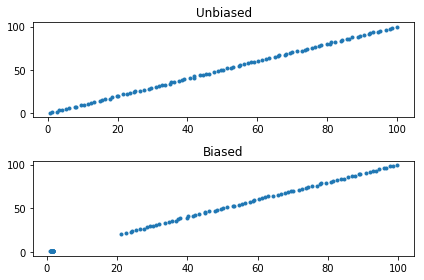

In [3]:
#Plot scatterplots

plt.figure; #Make new figure window

#Plot a 2 x 1 figure, in the top row the Unbiased data
plt.subplot(211); plt.plot(df['x'], df['y'], '.');
plt.title('Unbiased')

#And in the bottom the biased (wrong) data
plt.subplot(212); plt.plot(biased_df['x'], biased_df['y'], '.');
plt.title('Biased')
plt.tight_layout()

In [4]:
## fit
lm = linear_model.LinearRegression()
lm = lm.fit(df[['x']], df['y'])
print('MSE = {}'.format(metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))))
print('r2 = {}'.format(lm.score(df[['x']], df['y'])))

MSE = 0.17479357074520824
r2 = 0.9997903888754838


In [5]:
## biased fit
lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])
print(metrics.mean_squared_error(df['y'], lm.predict(df[['x']])))
print('r2 = {}'.format(lm.score(biased_df[['x']], biased_df['y'])))

0.18178278991703792
r2 = 0.9998318261034117


## Cross validation
#### Intro to cross validation with bike share data from last time. We will be modeling casual ridership. 

In [6]:
from sklearn import cross_validation
wd = '../../assets/dataset/'
bikeshare = pd.read_csv(wd + 'bikeshare.csv').dropna()
bikeshare.head()

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2,2011-01-01,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3,2011-01-01,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4,2011-01-01,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5,2011-01-01,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


#### Create dummy variables and set outcome (dependent) variable

In [7]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1.0', 'weather_2.0', 'weather_3.0']])
y = bikeshare.casual

modeldata.head()

,temp,hum,weather_1.0,weather_2.0,weather_3.0
0,0.24,0.81,1,0,0
1,0.22,0.80,1,0,0
2,0.22,0.80,1,0,0
3,0.24,0.75,1,0,0
4,0.24,0.75,1,0,0


In [8]:
pd.crosstab(modeldata['weather_1.0'], modeldata['weather_2.0'], modeldata['weather_3.0'], margins = True, aggfunc = 'count')

weather_2.0,0,1,All
weather_1.0,,,
0,276.0,819.0,1095
1,1541.0,NaN,1541
All,1817.0,819.0,2636


#### Create a cross valiation with 5 folds

In [9]:
kf = cross_validation.KFold(len(modeldata), n_folds = 5, shuffle = False) 

mse_values = []
scores = []
n = 0

for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print('Model', n)
    print('MSE:', mse_values[n-1])
    print('R2:', scores[n-1])


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds:', np.mean(mse_values))
print('Mean of R2 for all folds:', np.mean(scores))

Model 1
MSE: 62.10984721941031
R2: 0.3027063788073888
Model 2
MSE: 112.50264152954445
R2: 0.30041952744046907
Model 3
MSE: 341.77210522892767
R2: 0.29297780143203594
Model 4
MSE: 711.4507978930378
R2: 0.2979891501967816
Model 5
MSE: 1406.12153316711
R2: 0.29303466273864687
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 526.7913850076061
Mean of R2 for all folds: 0.29742550412306445


In [10]:
k_scores = []
k_mse = []

for l, k in enumerate(range(2,50)):
    kf = cross_validation.KFold(len(modeldata), n_folds = k, shuffle = False)
    mse_values = []
    scores = []
    n = 0

    for train_index, test_index in kf:
        lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
        mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
        scores.append(lm.score(modeldata, y))
        n+=1
        
    k_mse.append(np.mean(mse_values))
    k_scores.append(np.mean(scores))
    print('\nMean of {} folds MSE: {}'.format(k, k_mse[l]))
    print('Mean of {} folds r2: {}'.format(k, k_scores[l]))
    
    #Collect Mean cross val for each k
#         k_mse.append(np.mean(mse_values))
#         k_scores.append(np.mean(scores))
    



Mean of 2 folds MSE: 589.3779791429573
Mean of 2 folds r2: 0.2503109346632029

Mean of 3 folds MSE: 554.9778959879495
Mean of 3 folds r2: 0.2831279326288269

Mean of 4 folds MSE: 516.8249254801264
Mean of 4 folds r2: 0.29780048566182943

Mean of 5 folds MSE: 526.7913850076061
Mean of 5 folds r2: 0.29742550412306445

Mean of 6 folds MSE: 516.4256535515814
Mean of 6 folds r2: 0.30009848367503156

Mean of 7 folds MSE: 513.3067159321397
Mean of 7 folds r2: 0.30100363617798276

Mean of 8 folds MSE: 511.83624038675293
Mean of 8 folds r2: 0.3015757734331898

Mean of 9 folds MSE: 5.23158198558213e+25
Mean of 9 folds r2: -8.249534213959941e+21

Mean of 10 folds MSE: 511.3231301043664
Mean of 10 folds r2: 0.3020293327665448

Mean of 11 folds MSE: 513.3649152315651
Mean of 11 folds r2: 0.30204225621727765

Mean of 12 folds MSE: 510.7683479958655
Mean of 12 folds r2: 0.3023614384093726

Mean of 13 folds MSE: 510.00703470056396
Mean of 13 folds r2: 0.30248646362792375

Mean of 14 folds MSE: 510.85

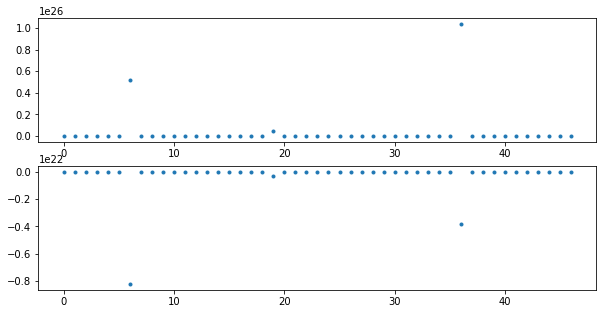

In [11]:
plt.figure(figsize = [10,5])
plt.subplot(211);
plt.plot(k_mse[1:], '.')

plt.subplot(212);
plt.plot(k_scores[1:], '.')

In [12]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print("~~~~ Single Model ~~~~")
print('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 490.90385072958526
R2:  0.30358099110400516


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

### There are ways to improve our model with regularization. 
Let's check out the effects on MSE and R2

In [13]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print("~~~ OLS ~~~")
print("OLS MSE: ", metrics.mean_squared_error(y, lm.predict(modeldata)))
print('OLS R2:', lm.score(modeldata, y))

lm = linear_model.Lasso().fit(modeldata, y)
print("~~~ Lasso ~~~")
print('Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata)))
print('Lasso R2:', lm.score(modeldata, y))

lm = linear_model.Ridge().fit(modeldata, y)
print("~~~ Ridge ~~~")
print('Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata)))
print('Ridge R2:', lm.score(modeldata, y))

~~~ OLS ~~~
OLS MSE:  490.90385072958526
OLS R2: 0.30358099110400516
~~~ Lasso ~~~
Lasso MSE:  567.3704001092815
Lasso R2: 0.195101991695954
~~~ Ridge ~~~
Ridge MSE:  490.98775926918324
Ridge R2: 0.3034619545515359


### Figuring out the alphas can be done by "hand"

In [14]:
alphas = np.logspace(-10, 10, 21)
mse = []
for a in alphas:
    print('Alpha:', a)
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
#     print lm.coef_
    mse.append(metrics.mean_squared_error(y, lm.predict(modeldata)))
    print(metrics.mean_squared_error(y, lm.predict(modeldata)))

Alpha: 1e-10
490.90385072958526
Alpha: 1e-09
490.90385072958526
Alpha: 1e-08
490.9038507295854
Alpha: 1e-07
490.9038507295854
Alpha: 1e-06
490.9038507295855
Alpha: 1e-05
490.90385072959697
Alpha: 0.0001
490.90385073074447
Alpha: 0.001
490.9038508453405
Alpha: 0.01
490.9038621454921
Alpha: 0.1
490.90488243242265
Alpha: 1.0
490.98775926918324
Alpha: 10.0
496.7023000553054
Alpha: 100.0
578.8915037466983
Alpha: 1000.0
675.6847178279737
Alpha: 10000.0
700.8243107672381
Alpha: 100000.0
704.4657724323305
Alpha: 1000000.0
704.8538394808153
Alpha: 10000000.0
704.8929146176345
Alpha: 100000000.0
704.8968248487064
Alpha: 1000000000.0
704.897215899021
Alpha: 10000000000.0
704.8972550043246


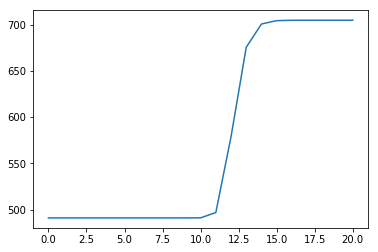

In [15]:
plt.plot(mse)

## Gradient Descent

In [16]:
num_to_approach, start, steps, optimized = 6.2, 0., [-5, 5], False

i = 0

while not optimized:
    current_distance = num_to_approach - start
    got_better = False
    next_steps = [start + i for i in steps]
    for n in next_steps:
        distance = np.abs(num_to_approach - n)
        if distance < current_distance:
            got_better = True
            print(distance, 'is better than', current_distance)
            current_distance = distance
            start = n
    if got_better:
        print('found better solution! using', current_distance)
        i += 1
    else:
        optimized = True
        print(start, 'is closest to', num_to_approach)

1.2000000000000002 is better than 6.2
found better solution! using 1.2000000000000002
5.0 is closest to 6.2


### Bonus: 
implement a stopping point, similar to what n_iter would do in gradient descent when we've reached "good enough"

## Demo: Application of Gradient Descent 

In [17]:
lm = linear_model.SGDRegressor()
lm.fit(modeldata, y)
print("Gradient Descent R2:", lm.score(modeldata, y))
print("Gradient Descent MSE:", metrics.mean_squared_error(y, lm.predict(modeldata)))


Gradient Descent R2: 0.1570681299866924
Gradient Descent MSE: 594.1803649906127


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [18]:
lm = linear_model.LinearRegression()
lm.fit(modeldata, y)
print(" R2:", lm.score(modeldata, y))
print("MSE:", metrics.mean_squared_error(y, lm.predict(modeldata)))

 R2: 0.30358099110400516
MSE: 490.90385072958526


### Check: Untuned, how well did gradient descent perform compared to OLS?

Answer: 

# Independent Practice: Bike data revisited

There are tons of ways to approach a regression problem. The regularization techniques appended to ordinary least squares optimizes the size of coefficients to best account for error. Gradient Descent also introduces learning rate (how aggressively do we solve the problem), epsilon (at what point do we say the error margin is acceptable), and iterations (when should we stop no matter what?)

For this deliverable, our goals are to:

- implement the gradient descent approach to our bike-share modeling problem,
- show how gradient descent solves and optimizes the solution,
- demonstrate the grid_search module!

While exploring the Gradient Descent regressor object, you'll build a grid search using the stochastic gradient descent estimator for the bike-share data set. Continue with either the model you evaluated last class or the simpler one from today. In particular, be sure to implement the "param_grid" in the grid search to get answers for the following questions:

- With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
- Based on the data, we know when to properly use l1 vs l2 regularization. By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does that statement hold true? If not, did gradient descent have enough iterations?
- How do these results change when you alter the learning rate (eta0)?

**Bonus**: Can you see the advantages and disadvantages of using gradient descent after finishing this exercise?

### Starter Code

In [19]:
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print('BEST ESTIMATOR')
print(-gs.best_score_)
print(gs.best_estimator_)
print('ALL ESTIMATORS')
print(gs.grid_scores_)

NameError: name 'grid_search' is not defined

In [ ]:
## go for it!